# Advanced Attention Mechanisms: GQA, MLA, and KV Cache

This notebook explores modern attention mechanisms and optimization techniques for efficient LLM inference.

We'll cover:
1. **Multi-Head Attention (MHA)** - Baseline
2. **Multi-Query Attention (MQA)** - Single K/V head
3. **Grouped Query Attention (GQA)** - Middle ground (used in LLaMA 2)
4. **Multi-Head Latent Attention (MLA)** - Low-rank compression
5. **KV Cache** - Critical for autoregressive inference
6. **Performance comparisons**

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import time
from typing import Optional, Tuple

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Standard Multi-Head Attention (MHA)

Traditional MHA has **separate Q, K, V heads for each attention head**:
- H heads, each with separate Q, K, V projections
- Memory: O(H × d)
- Used in: Original Transformer, GPT-2, GPT-3

$$\text{MHA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_H)W^O$$
$$\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$

In [2]:
class MultiHeadAttention(nn.Module):
    """
    Standard Multi-Head Attention (MHA).
    Each head has its own Q, K, V projections.
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Separate projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x, mask=None, kv_cache=None, use_cache=False):
        """
        Args:
            x: Input (batch_size, seq_len, d_model)
            mask: Attention mask
            kv_cache: Cached K, V from previous steps
            use_cache: Whether to return cache for next step
        """
        batch_size, seq_len, _ = x.shape
        
        # Project to Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # Reshape for multi-head: (batch, seq_len, num_heads, head_dim)
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Handle KV cache for autoregressive generation
        if kv_cache is not None:
            past_k, past_v = kv_cache
            k = torch.cat([past_k, k], dim=1)
            v = torch.cat([past_v, v], dim=1)
        
        # Transpose for attention: (batch, num_heads, seq_len, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        out = torch.matmul(attn_weights, v)
        
        # Reshape and project
        out = out.transpose(1, 2).contiguous()
        out = out.view(batch_size, seq_len, self.d_model)
        out = self.out_proj(out)
        
        new_cache = (k.transpose(1, 2), v.transpose(1, 2)) if use_cache else None
        return out, attn_weights, new_cache

# Example
mha = MultiHeadAttention(d_model=512, num_heads=8)
x = torch.randn(2, 10, 512)
out, attn, cache = mha(x, use_cache=True)

print(f"MHA - Input: {x.shape}")
print(f"MHA - Output: {out.shape}")
print(f"MHA - Attention: {attn.shape}")
print(f"MHA - Parameters: {sum(p.numel() for p in mha.parameters()):,}")
if cache:
    print(f"MHA - Cache K shape: {cache[0].shape}, Cache V shape: {cache[1].shape}")

MHA - Input: torch.Size([2, 10, 512])
MHA - Output: torch.Size([2, 10, 512])
MHA - Attention: torch.Size([2, 8, 10, 10])
MHA - Parameters: 1,050,624
MHA - Cache K shape: torch.Size([2, 10, 8, 64]), Cache V shape: torch.Size([2, 10, 8, 64])


## 3. Multi-Query Attention (MQA)

MQA uses **single shared K and V** across all heads:
- H query heads, but only 1 K head and 1 V head
- Memory: O(d) for K, V (much smaller!)
- Used in: PaLM, Falcon

**Key benefit:** Dramatically reduces KV cache size during inference

**Trade-off:** Slightly lower quality than MHA

In [3]:
class MultiQueryAttention(nn.Module):
    """
    Multi-Query Attention (MQA).
    Multiple query heads, but single shared K and V.
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Multiple query heads
        self.q_proj = nn.Linear(d_model, d_model)
        
        # Single K and V (shared across all heads)
        self.k_proj = nn.Linear(d_model, self.head_dim)
        self.v_proj = nn.Linear(d_model, self.head_dim)
        
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x, mask=None, kv_cache=None, use_cache=False):
        batch_size, seq_len, _ = x.shape
        
        # Project queries (multiple heads)
        q = self.q_proj(x)
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Project K, V (single head, will be broadcast)
        k = self.k_proj(x)  # (batch, seq_len, head_dim)
        v = self.v_proj(x)  # (batch, seq_len, head_dim)
        
        # Handle KV cache
        if kv_cache is not None:
            past_k, past_v = kv_cache
            k = torch.cat([past_k, k], dim=1)
            v = torch.cat([past_v, v], dim=1)
        
        # Reshape for broadcasting
        # Q: (batch, num_heads, seq_len, head_dim)
        # K, V: (batch, 1, kv_seq_len, head_dim) - will broadcast across heads
        q = q.transpose(1, 2)
        k = k.unsqueeze(1)  # Add head dimension for broadcasting
        v = v.unsqueeze(1)
        
        # Compute attention (K, V broadcast across all query heads)
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        out = torch.matmul(attn_weights, v)
        
        # Reshape and project
        out = out.transpose(1, 2).contiguous()
        out = out.view(batch_size, seq_len, self.d_model)
        out = self.out_proj(out)
        
        # Cache stores only single K, V (not per-head)
        new_cache = (k.squeeze(1), v.squeeze(1)) if use_cache else None
        return out, attn_weights, new_cache

# Example
mqa = MultiQueryAttention(d_model=512, num_heads=8)
x = torch.randn(2, 10, 512)
out, attn, cache = mqa(x, use_cache=True)

print(f"\nMQA - Input: {x.shape}")
print(f"MQA - Output: {out.shape}")
print(f"MQA - Attention: {attn.shape}")
print(f"MQA - Parameters: {sum(p.numel() for p in mqa.parameters()):,}")
if cache:
    print(f"MQA - Cache K shape: {cache[0].shape}, Cache V shape: {cache[1].shape}")
    print(f"MQA - Cache is {mha.num_heads}x smaller than MHA!")


MQA - Input: torch.Size([2, 10, 512])
MQA - Output: torch.Size([2, 10, 512])
MQA - Attention: torch.Size([2, 8, 10, 10])
MQA - Parameters: 590,976
MQA - Cache K shape: torch.Size([2, 10, 64]), Cache V shape: torch.Size([2, 10, 64])
MQA - Cache is 8x smaller than MHA!


## 4. Grouped Query Attention (GQA)

GQA is the **middle ground between MHA and MQA**:
- H query heads divided into G groups
- Each group shares one K and V head
- Memory: O(G × d) where G < H
- Used in: **LLaMA 2, Mistral**

**Benefits:**
- Better quality than MQA (more K/V diversity)
- Smaller cache than MHA
- Good balance for production LLMs

Example: 32 query heads → 8 KV groups (4 queries per KV head)

In [4]:
class GroupedQueryAttention(nn.Module):
    """
    Grouped Query Attention (GQA).
    Query heads are divided into groups, each group shares K and V.
    Used in LLaMA 2.
    """
    def __init__(self, d_model, num_heads, num_kv_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        assert num_heads % num_kv_heads == 0, "num_heads must be divisible by num_kv_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads
        self.head_dim = d_model // num_heads
        self.num_queries_per_kv = num_heads // num_kv_heads
        
        # Query projection (all heads)
        self.q_proj = nn.Linear(d_model, d_model)
        
        # K, V projections (num_kv_heads)
        self.k_proj = nn.Linear(d_model, num_kv_heads * self.head_dim)
        self.v_proj = nn.Linear(d_model, num_kv_heads * self.head_dim)
        
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x, mask=None, kv_cache=None, use_cache=False):
        batch_size, seq_len, _ = x.shape
        
        # Project Q (all heads)
        q = self.q_proj(x)
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Project K, V (num_kv_heads)
        k = self.k_proj(x)
        v = self.v_proj(x)
        k = k.view(batch_size, seq_len, self.num_kv_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_kv_heads, self.head_dim)
        
        # Handle KV cache
        if kv_cache is not None:
            past_k, past_v = kv_cache
            k = torch.cat([past_k, k], dim=1)
            v = torch.cat([past_v, v], dim=1)
        
        # Transpose: (batch, num_heads, seq_len, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Repeat K, V for each group
        # Shape: (batch, num_heads, seq_len, head_dim)
        k = k.repeat_interleave(self.num_queries_per_kv, dim=1)
        v = v.repeat_interleave(self.num_queries_per_kv, dim=1)
        
        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        out = torch.matmul(attn_weights, v)
        
        # Reshape and project
        out = out.transpose(1, 2).contiguous()
        out = out.view(batch_size, seq_len, self.d_model)
        out = self.out_proj(out)
        
        # Cache stores only num_kv_heads (not all num_heads)
        if use_cache:
            k_cache = k[:, ::self.num_queries_per_kv, :, :].transpose(1, 2)
            v_cache = v[:, ::self.num_queries_per_kv, :, :].transpose(1, 2)
            new_cache = (k_cache, v_cache)
        else:
            new_cache = None
        
        return out, attn_weights, new_cache

# Example: 8 heads with 2 KV heads (4 queries per KV)
gqa = GroupedQueryAttention(d_model=512, num_heads=8, num_kv_heads=2)
x = torch.randn(2, 10, 512)
out, attn, cache = gqa(x, use_cache=True)

print(f"\nGQA - Input: {x.shape}")
print(f"GQA - Output: {out.shape}")
print(f"GQA - Attention: {attn.shape}")
print(f"GQA - Parameters: {sum(p.numel() for p in gqa.parameters()):,}")
print(f"GQA - Queries per KV: {gqa.num_queries_per_kv}")
if cache:
    print(f"GQA - Cache K shape: {cache[0].shape}, Cache V shape: {cache[1].shape}")
    print(f"GQA - Cache is {mha.num_heads // gqa.num_kv_heads}x smaller than MHA!")


GQA - Input: torch.Size([2, 10, 512])
GQA - Output: torch.Size([2, 10, 512])
GQA - Attention: torch.Size([2, 8, 10, 10])
GQA - Parameters: 656,640
GQA - Queries per KV: 4
GQA - Cache K shape: torch.Size([2, 10, 2, 64]), Cache V shape: torch.Size([2, 10, 2, 64])
GQA - Cache is 4x smaller than MHA!


## 5. Multi-Head Latent Attention (MLA)

MLA uses **low-rank compression** of K and V:
- Projects K, V to lower-dimensional latent space
- Stores compressed representation
- Decompresses for attention computation
- Used in: DeepSeek-V2

**Key innovation:**
- KV cache size reduced by ~90%
- Compression ratio configurable
- Minimal quality loss with proper tuning

In [6]:
class MultiHeadLatentAttention(nn.Module):
    """
    Multi-Head Latent Attention (MLA).
    Compresses K, V into low-rank latent representation.
    """
    def __init__(self, d_model, num_heads, latent_dim=None, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Latent dimension (compressed representation)
        # Typically much smaller than d_model
        self.latent_dim = latent_dim or (d_model // 4)
        
        # Query projection (full dimension)
        self.q_proj = nn.Linear(d_model, d_model)
        
        # Compress to latent space
        self.kv_compress = nn.Linear(d_model, self.latent_dim)
        
        # Decompress from latent to K, V
        self.k_decompress = nn.Linear(self.latent_dim, d_model)
        self.v_decompress = nn.Linear(self.latent_dim, d_model)
        
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x, mask=None, kv_cache=None, use_cache=False):
        batch_size, seq_len, _ = x.shape
        
        # Query projection (full dimension)
        q = self.q_proj(x)
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Compress to latent space
        kv_latent = self.kv_compress(x)  # (batch, seq_len, latent_dim)
        
        # Handle KV cache (cache stores compressed latent!)
        if kv_cache is not None:
            past_latent = kv_cache
            kv_latent = torch.cat([past_latent, kv_latent], dim=1)
        
        # Decompress to K, V
        k = self.k_decompress(kv_latent)
        v = self.v_decompress(kv_latent)
        
        k = k.view(batch_size, -1, self.num_heads, self.head_dim)
        v = v.view(batch_size, -1, self.num_heads, self.head_dim)
        
        # Transpose for attention
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        out = torch.matmul(attn_weights, v)
        
        # Reshape and project
        out = out.transpose(1, 2).contiguous()
        out = out.view(batch_size, seq_len, self.d_model)
        out = self.out_proj(out)
        
        # Cache stores compressed latent (much smaller!)
        new_cache = kv_latent if use_cache else None
        return out, attn_weights, new_cache

# Example: latent_dim = d_model // 4 (4x compression)
mla = MultiHeadLatentAttention(d_model=512, num_heads=8, latent_dim=128)
x = torch.randn(2, 10, 512)
out, attn, cache = mla(x, use_cache=True)

print(f"\nMLA - Input: {x.shape}")
print(f"MLA - Output: {out.shape}")
print(f"MLA - Attention: {attn.shape}")
print(f"MLA - Parameters: {sum(p.numel() for p in mla.parameters()):,}")
print(f"MLA - Latent dimension: {mla.latent_dim} (compression: {mla.d_model / mla.latent_dim:.1f}x)")
if cache is not None:
    print(f"MLA - Cache shape: {cache.shape}")
    print(f"MLA - Cache is ~{mla.d_model / mla.latent_dim:.1f}x smaller than MHA per element!")


MLA - Input: torch.Size([2, 10, 512])
MLA - Output: torch.Size([2, 10, 512])
MLA - Attention: torch.Size([2, 8, 10, 10])
MLA - Parameters: 723,072
MLA - Latent dimension: 128 (compression: 4.0x)
MLA - Cache shape: torch.Size([2, 10, 128])
MLA - Cache is ~4.0x smaller than MHA per element!


## 6. KV Cache Visualization and Analysis

The KV cache is crucial for efficient autoregressive generation:
- Store K, V from previous tokens
- Reuse for each new token
- Avoid recomputing attention for entire sequence

**Without KV cache:** O(n²) for n tokens
**With KV cache:** O(n) for n tokens

In [7]:
def demonstrate_kv_cache():
    """
    Demonstrate KV cache usage in autoregressive generation.
    """
    d_model = 256
    num_heads = 8
    batch_size = 1
    
    mha = MultiHeadAttention(d_model, num_heads)
    
    print("=== Autoregressive Generation with KV Cache ===")
    print()
    
    # Initial prompt
    prompt_len = 5
    x_prompt = torch.randn(batch_size, prompt_len, d_model)
    
    print(f"Step 1: Process prompt (length {prompt_len})")
    out, _, cache = mha(x_prompt, use_cache=True)
    print(f"  Cache K shape: {cache[0].shape}")
    print(f"  Cache V shape: {cache[1].shape}")
    print(f"  Total cache size: {cache[0].numel() + cache[1].numel()} elements")
    
    # Generate tokens one by one
    num_new_tokens = 3
    for i in range(num_new_tokens):
        print(f"\nStep {i+2}: Generate token {i+1}")
        
        # Process single new token
        x_new = torch.randn(batch_size, 1, d_model)
        out, _, cache = mha(x_new, kv_cache=cache, use_cache=True)
        
        print(f"  Input: {x_new.shape}")
        print(f"  Cache K shape: {cache[0].shape} (grew by 1)")
        print(f"  Cache V shape: {cache[1].shape} (grew by 1)")
    
    print(f"\nFinal sequence length: {prompt_len + num_new_tokens}")
    print(f"Final cache size: {cache[0].shape}")

demonstrate_kv_cache()

=== Autoregressive Generation with KV Cache ===

Step 1: Process prompt (length 5)
  Cache K shape: torch.Size([1, 5, 8, 32])
  Cache V shape: torch.Size([1, 5, 8, 32])
  Total cache size: 2560 elements

Step 2: Generate token 1
  Input: torch.Size([1, 1, 256])
  Cache K shape: torch.Size([1, 6, 8, 32]) (grew by 1)
  Cache V shape: torch.Size([1, 6, 8, 32]) (grew by 1)

Step 3: Generate token 2
  Input: torch.Size([1, 1, 256])
  Cache K shape: torch.Size([1, 7, 8, 32]) (grew by 1)
  Cache V shape: torch.Size([1, 7, 8, 32]) (grew by 1)

Step 4: Generate token 3
  Input: torch.Size([1, 1, 256])
  Cache K shape: torch.Size([1, 8, 8, 32]) (grew by 1)
  Cache V shape: torch.Size([1, 8, 8, 32]) (grew by 1)

Final sequence length: 8
Final cache size: torch.Size([1, 8, 8, 32])


## 7. Memory Comparison

Compare KV cache memory usage across different attention mechanisms.

=== KV Cache Memory Comparison ===
Configuration:
  Model: d_model=4096, num_heads=32, layers=32
  Generation: batch=1, seq_len=2048
  Precision: FP16 (2 bytes/param)

MHA (Multi-Head Attention):
  Total cache: 1.00 GB
  Baseline (1.0x)

MQA (Multi-Query Attention):
  Total cache: 32.00 MB
  Reduction: 32.0x smaller (96.9% less)

GQA (Grouped Query Attention):
  Total cache: 256.00 MB
  Reduction: 4.0x smaller (75.0% less)

MLA (Multi-Head Latent Attention):
  Total cache: 128.00 MB
  Reduction: 8.0x smaller (87.5% less)



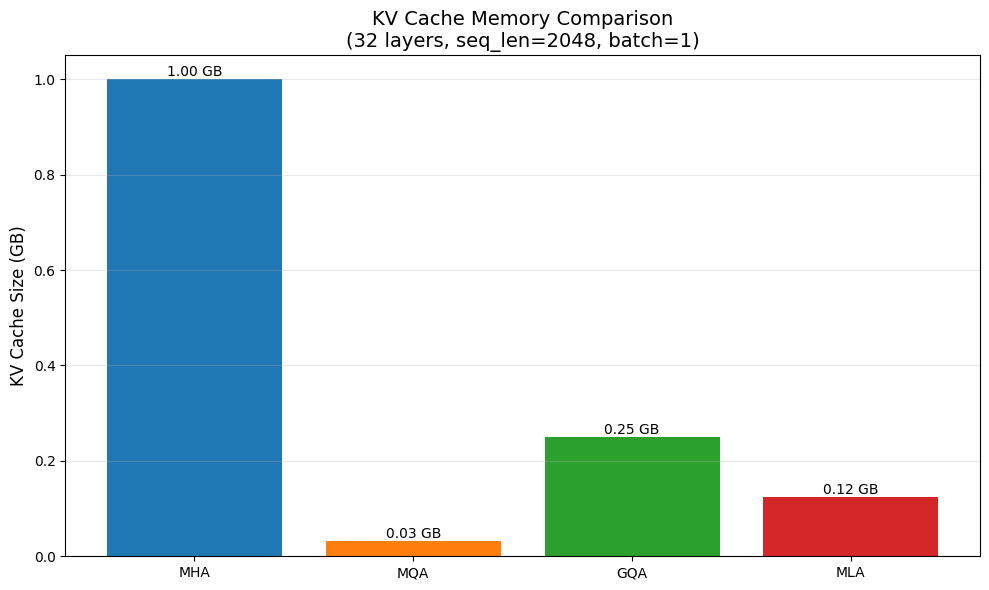

In [8]:
def compare_kv_cache_memory():
    """
    Compare KV cache memory requirements across attention variants.
    """
    # Model configuration
    d_model = 4096
    num_heads = 32
    num_kv_heads = 8  # For GQA
    latent_dim = 1024  # For MLA
    
    # Generation settings
    batch_size = 1
    seq_len = 2048
    num_layers = 32
    
    head_dim = d_model // num_heads
    bytes_per_param = 2  # FP16
    
    # Calculate cache size for each method
    # Cache stores K and V for each layer
    
    # MHA: num_heads * head_dim = d_model per K or V
    mha_cache_per_layer = 2 * batch_size * seq_len * d_model
    mha_total = mha_cache_per_layer * num_layers * bytes_per_param
    
    # MQA: single head_dim per K or V
    mqa_cache_per_layer = 2 * batch_size * seq_len * head_dim
    mqa_total = mqa_cache_per_layer * num_layers * bytes_per_param
    
    # GQA: num_kv_heads * head_dim
    gqa_cache_per_layer = 2 * batch_size * seq_len * num_kv_heads * head_dim
    gqa_total = gqa_cache_per_layer * num_layers * bytes_per_param
    
    # MLA: latent_dim (compressed)
    mla_cache_per_layer = batch_size * seq_len * latent_dim
    mla_total = mla_cache_per_layer * num_layers * bytes_per_param
    
    # Print results
    print("=== KV Cache Memory Comparison ===")
    print(f"Configuration:")
    print(f"  Model: d_model={d_model}, num_heads={num_heads}, layers={num_layers}")
    print(f"  Generation: batch={batch_size}, seq_len={seq_len}")
    print(f"  Precision: FP16 ({bytes_per_param} bytes/param)")
    print()
    
    def format_size(bytes_val):
        mb = bytes_val / (1024 ** 2)
        gb = bytes_val / (1024 ** 3)
        if gb >= 1:
            return f"{gb:.2f} GB"
        return f"{mb:.2f} MB"
    
    print(f"MHA (Multi-Head Attention):")
    print(f"  Total cache: {format_size(mha_total)}")
    print(f"  Baseline (1.0x)")
    print()
    
    print(f"MQA (Multi-Query Attention):")
    print(f"  Total cache: {format_size(mqa_total)}")
    print(f"  Reduction: {mha_total / mqa_total:.1f}x smaller ({100 * (1 - mqa_total/mha_total):.1f}% less)")
    print()
    
    print(f"GQA (Grouped Query Attention):")
    print(f"  Total cache: {format_size(gqa_total)}")
    print(f"  Reduction: {mha_total / gqa_total:.1f}x smaller ({100 * (1 - gqa_total/mha_total):.1f}% less)")
    print()
    
    print(f"MLA (Multi-Head Latent Attention):")
    print(f"  Total cache: {format_size(mla_total)}")
    print(f"  Reduction: {mha_total / mla_total:.1f}x smaller ({100 * (1 - mla_total/mha_total):.1f}% less)")
    print()
    
    # Visualization
    methods = ['MHA', 'MQA', 'GQA', 'MLA']
    sizes_gb = [mha_total / (1024**3), mqa_total / (1024**3), 
                gqa_total / (1024**3), mla_total / (1024**3)]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, sizes_gb, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylabel('KV Cache Size (GB)', fontsize=12)
    plt.title(f'KV Cache Memory Comparison\n({num_layers} layers, seq_len={seq_len}, batch={batch_size})', 
              fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, size in zip(bars, sizes_gb):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{size:.2f} GB',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

compare_kv_cache_memory()

## 8. Performance Comparison

Compare computational efficiency of different attention mechanisms.

=== Attention Mechanism Benchmark ===
Configuration: batch=4, seq_len=128, d_model=512
Iterations: 100

MHA     : 12.555 ms/iteration
MQA     : 7.401 ms/iteration
GQA     : 7.502 ms/iteration
MLA     : 9.659 ms/iteration


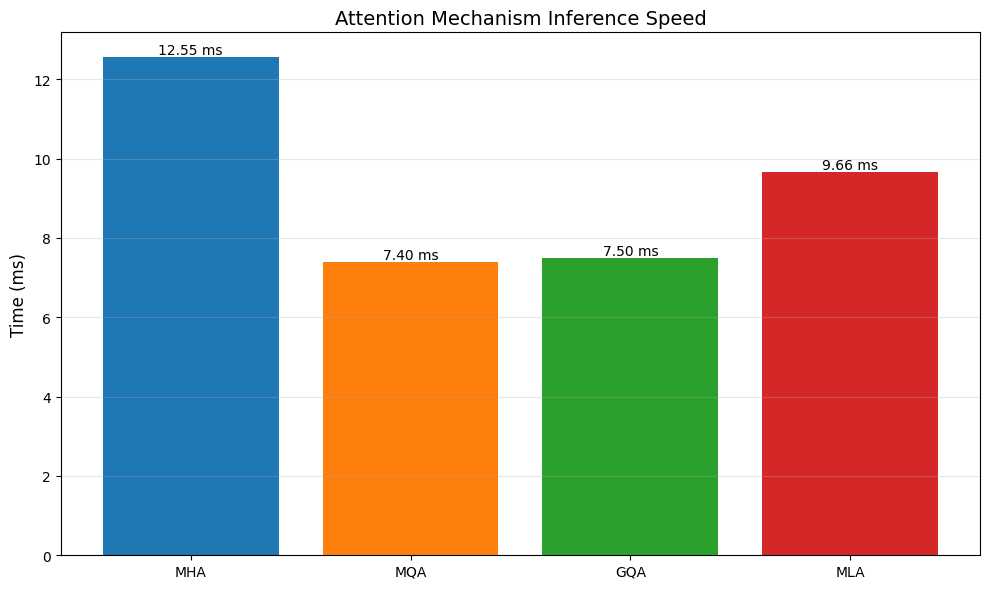

In [9]:
def benchmark_attention_variants():
    """
    Benchmark inference speed of different attention mechanisms.
    """
    d_model = 512
    num_heads = 8
    batch_size = 4
    seq_len = 128
    num_iterations = 100
    
    # Initialize models
    models = {
        'MHA': MultiHeadAttention(d_model, num_heads),
        'MQA': MultiQueryAttention(d_model, num_heads),
        'GQA': GroupedQueryAttention(d_model, num_heads, num_kv_heads=2),
        'MLA': MultiHeadLatentAttention(d_model, num_heads, latent_dim=128)
    }
    
    # Set to eval mode
    for model in models.values():
        model.eval()
    
    # Benchmark
    results = {}
    
    print("=== Attention Mechanism Benchmark ===")
    print(f"Configuration: batch={batch_size}, seq_len={seq_len}, d_model={d_model}")
    print(f"Iterations: {num_iterations}\n")
    
    with torch.no_grad():
        for name, model in models.items():
            x = torch.randn(batch_size, seq_len, d_model)
            
            # Warmup
            for _ in range(10):
                _ = model(x)
            
            # Benchmark
            start = time.time()
            for _ in range(num_iterations):
                _ = model(x)
            end = time.time()
            
            avg_time = (end - start) / num_iterations * 1000  # ms
            results[name] = avg_time
            
            print(f"{name:8s}: {avg_time:.3f} ms/iteration")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    names = list(results.keys())
    times = list(results.values())
    
    bars = plt.bar(names, times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylabel('Time (ms)', fontsize=12)
    plt.title('Attention Mechanism Inference Speed', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.2f} ms',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

benchmark_attention_variants()

## 9. Trade-off Analysis

Summarize the trade-offs between different attention mechanisms.

In [10]:
import pandas as pd

# Create comprehensive comparison table
comparison = {
    'Method': ['MHA', 'MQA', 'GQA', 'MLA'],
    'KV Heads': ['H', '1', 'G (1 < G < H)', 'H'],
    'KV Cache Size': ['H × d', 'd', 'G × d', 'latent_dim'],
    'Quality': ['Best', 'Good', 'Very Good', 'Very Good'],
    'Memory': ['High', 'Low', 'Medium', 'Very Low'],
    'Speed': ['Baseline', 'Faster', 'Fast', 'Variable'],
    'Used In': ['GPT-3', 'PaLM, Falcon', 'LLaMA 2, Mistral', 'DeepSeek-V2']
}

df = pd.DataFrame(comparison)

print("\n=== Attention Mechanism Comparison ===")
print(df.to_string(index=False))
print()

print("Key Insights:")
print()
print("1. **MHA (Multi-Head Attention)**")
print("   - Best quality but highest memory")
print("   - Used in earlier large models (GPT-3)")
print("   - Each head has independent K, V")
print()
print("2. **MQA (Multi-Query Attention)**")
print("   - Dramatic memory reduction (H× smaller)")
print("   - Single shared K, V across all heads")
print("   - Slight quality degradation")
print("   - Fast inference due to smaller cache")
print()
print("3. **GQA (Grouped Query Attention)**")
print("   - Best balance: quality vs. memory")
print("   - Industry standard for modern LLMs")
print("   - LLaMA 2: 32 Q heads, 8 KV heads (4× reduction)")
print("   - Mistral: Similar configuration")
print()
print("4. **MLA (Multi-Head Latent Attention)**")
print("   - Lowest memory via compression")
print("   - ~90% KV cache reduction")
print("   - Adds compression/decompression overhead")
print("   - Cutting-edge research (DeepSeek-V2)")
print()

# Practical recommendations
print("\n=== Practical Recommendations ===")
print()
print("Use **GQA** for:")
print("  ✓ Production LLM deployments")
print("  ✓ Long context windows (32K+ tokens)")
print("  ✓ Memory-constrained environments")
print("  ✓ High-quality generation requirements")
print()
print("Use **MQA** for:")
print("  ✓ Maximum speed requirements")
print("  ✓ Extreme memory constraints")
print("  ✓ Applications where quality loss is acceptable")
print()
print("Use **MLA** for:")
print("  ✓ Research and experimentation")
print("  ✓ Ultra-long contexts (100K+ tokens)")
print("  ✓ When willing to trade computation for memory")
print()
print("Use **MHA** for:")
print("  ✓ Small models where memory isn't critical")
print("  ✓ Research baselines")
print("  ✓ Maximum quality requirements")


=== Attention Mechanism Comparison ===
Method      KV Heads KV Cache Size   Quality   Memory    Speed          Used In
   MHA             H         H × d      Best     High Baseline            GPT-3
   MQA             1             d      Good      Low   Faster     PaLM, Falcon
   GQA G (1 < G < H)         G × d Very Good   Medium     Fast LLaMA 2, Mistral
   MLA             H    latent_dim Very Good Very Low Variable      DeepSeek-V2

Key Insights:

1. **MHA (Multi-Head Attention)**
   - Best quality but highest memory
   - Used in earlier large models (GPT-3)
   - Each head has independent K, V

2. **MQA (Multi-Query Attention)**
   - Dramatic memory reduction (H× smaller)
   - Single shared K, V across all heads
   - Slight quality degradation
   - Fast inference due to smaller cache

3. **GQA (Grouped Query Attention)**
   - Best balance: quality vs. memory
   - Industry standard for modern LLMs
   - LLaMA 2: 32 Q heads, 8 KV heads (4× reduction)
   - Mistral: Similar configuratio

## 10. Summary

### Key Concepts Covered

1. **Multi-Head Attention (MHA)**
   - Traditional approach with separate K, V for each head
   - High quality but memory-intensive

2. **Multi-Query Attention (MQA)**
   - Single shared K, V across all heads
   - Massive memory savings
   - Used in PaLM, Falcon

3. **Grouped Query Attention (GQA)**
   - Middle ground: groups of queries share K, V
   - Industry standard for modern LLMs
   - **LLaMA 2, Mistral use GQA**

4. **Multi-Head Latent Attention (MLA)**
   - Low-rank compression of K, V
   - Cutting-edge memory optimization
   - Used in DeepSeek-V2

5. **KV Cache**
   - Essential for efficient autoregressive generation
   - Stores K, V from previous tokens
   - Reduces O(n²) to O(n) complexity

### Memory Savings Example (32-layer model, 2K context)
- MHA: ~4 GB KV cache
- GQA: ~1 GB KV cache (4× reduction)
- MQA: ~128 MB KV cache (32× reduction)
- MLA: ~512 MB KV cache (8× reduction)

### Production Best Practices
1. **Use GQA** for most production deployments
2. **Implement KV cache** for all autoregressive models
3. **Monitor cache size** as context grows
4. **Consider MQA** for edge deployments
5. **Explore MLA** for extreme context lengths

Understanding these attention mechanisms is critical for:
- Building efficient LLM inference systems
- Optimizing memory usage
- Scaling to longer contexts
- Making informed architecture decisions